# Marketing analysis. Multi-touch attribution


# Data preps

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
#from pandasql import sqldf
import itertools
from collections import defaultdict
from itertools import permutations,combinations

In [2]:
df = pd.read_csv('mta_data.csv')
df['steps'] = df.path.apply(lambda x: x[0:].split(' > '))

Data -- is the preprocessed conversion chains. For each chain we know # of conversions, their value and so on

In [3]:
df.head()

,path,total_conversions,total_conversion_value,total_null,steps
0,eta > iota > alpha > eta,1,0.244,3,"[eta, iota, alpha, eta]"
1,iota > iota > iota > iota,2,3.195,6,"[iota, iota, iota, iota]"
2,alpha > iota > alpha > alpha > alpha > iota > ...,2,6.754,6,"[alpha, iota, alpha, alpha, alpha, iota, alpha..."
3,beta > eta,1,2.402,3,"[beta, eta]"
4,iota > eta > theta > lambda > lambda > theta >...,0,0.000,2,"[iota, eta, theta, lambda, lambda, theta, lambda]"


<AxesSubplot:>

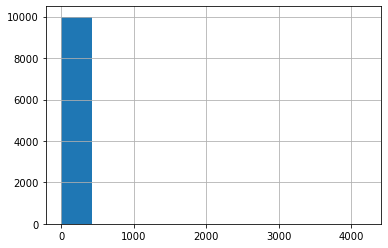

In [4]:
df.total_conversions.hist()

### Deleting the outliers

In [5]:
#df = df[(np.abs(stats.zscore(df['total_conversions'])) < 3)]
df = df[df['total_conversions'] < 5]

<AxesSubplot:>

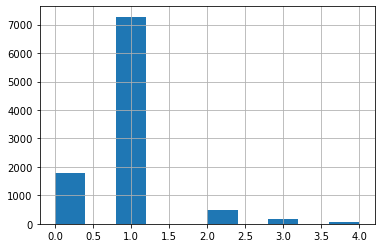

In [6]:
df.total_conversions.hist()

In [32]:
def get_channels(channel_lists):
    channels = []
    for steps in channel_lists:
        for step in steps:
            if step in channels: pass
            else: channels.append(step) 
    return channels

get_channels(df.steps)

['eta',
 'iota',
 'alpha',
 'beta',
 'theta',
 'lambda',
 'kappa',
 'zeta',
 'epsilon',
 'gamma',
 'delta',
 'mi']

# Markov Chains

Source:

https://github.com/jmwoloso/pychattr


In [62]:
#pip install pychattr

In [67]:
from pychattr.channel_attribution import MarkovModel

path_feature="path"
conversion_feature="total_conversions"
null_feature=None
revenue_feature="total_conversion_value"
cost_feature=None
separator=">"
k_order=1
n_simulations=10000
max_steps=None
return_transition_probs=True
random_state=26

# instantiate the model
mm = MarkovModel(path_feature=path_feature,
                 conversion_feature=conversion_feature,
                 null_feature=null_feature,
                 revenue_feature=revenue_feature,
                 cost_feature=cost_feature,
                 separator=separator,
                 k_order=k_order,
                 n_simulations=n_simulations,
                 max_steps=max_steps,
                 return_transition_probs=return_transition_probs,
                 random_state=random_state)

# fit the model
mm.fit(df)

In [68]:
# view the simulation results
print(mm.attribution_model_)

   channel_name  total_conversions  total_revenue
0           eta        1807.850113    7908.155669
1          iota        1715.904683    7465.950481
2         alpha        1272.783062    5684.244695
3          beta        1512.640706    6615.384648
4         theta         957.278007    4173.873998
5        lambda         701.122344    3152.243141
6         kappa         191.271096     867.779822
7          zeta         269.378585    1168.001639
8       epsilon         389.922426    1642.372083
9         gamma         121.158861     646.610819
10        delta           2.767588      10.232374
11           mi           0.922529       2.734575


In [70]:
# view the removal effects
print(mm.removal_effects_)

   channel_name  removal_effect  removal_effect_value
0           eta          0.5879              0.584404
1          iota          0.5580              0.551726
2         alpha          0.4139              0.420060
3          beta          0.4919              0.488870
4         theta          0.3113              0.308445
5        lambda          0.2280              0.232947
6         kappa          0.0622              0.064128
7          zeta          0.0876              0.086314
8       epsilon          0.1268              0.121370
9         gamma          0.0394              0.047784
10        delta          0.0009              0.000756
11           mi          0.0003              0.000202


Eta, iota and alpha are the champions

# Shapley

Source:

https://www.kaggle.com/code/jasonbrewster/shapley-value-attribution-modeling/notebook

## Data prep

In [7]:
for_shap = df.groupby(['path']).sum().reset_index().drop(['total_null'],axis=1)
for_shap = for_shap.rename(columns={"path": "channels_subset"})

In [8]:
for_shap

,channels_subset,total_conversions,total_conversion_value
0,alpha > alpha > alpha > alpha > alpha > alpha ...,4,8.096000
1,alpha > alpha > alpha > alpha > alpha > alpha ...,4,10.296000
2,alpha > alpha > alpha > alpha > alpha > alpha ...,2,12.649706
3,alpha > alpha > alpha > alpha > alpha > alpha ...,1,11.440000
4,alpha > alpha > alpha > alpha > alpha > alpha ...,1,3.500000
...,...,...,...
5363,zeta > zeta > zeta > iota > beta > iota > iota...,1,3.956000
5364,zeta > zeta > zeta > iota > zeta > zeta > alph...,1,2.300000
5365,zeta > zeta > zeta > lambda > lambda > theta >...,1,5.240000
5366,zeta > zeta > zeta > zeta > iota > zeta > alph...,1,2.400000


## Declare functions

Create a function that returns all possible combination of the channel

In [9]:
def power_set(List):
    PS = [list(j) for i in range(len(List)) for j in itertools.combinations(List, i+1)]
    return PS

Return all the possible subsets of a set of channels

In [10]:
def subsets(s):
    '''
    This function returns all the possible subsets of a set of channels.
    input :
            - s: a set of channels.
    '''
    if len(s)==1:
        return s
    else:
        sub_channels=[]
        for i in range(1,len(s)+1):
            sub_channels.extend(map(list,itertools.combinations(s, i)))
    return list(map(",".join,map(sorted,sub_channels)))

Computes the worth of each coalition.

In [11]:
def v_function(A,C_values):
    '''
    This function computes the worth of each coalition.
    inputs:
            - A : a coalition of channels.
            - C_values : A dictionnary containing the number of conversions that each subset of channels has yielded.
    '''
    subsets_of_A = subsets(A)
    #print(subsets_of_A)
    #exit()
    worth_of_A=0
    for subset in subsets_of_A:
        #print("subset:", subset)
        if subset in C_values:
            #print("subset:", subset, "; Value:", C_values[subset])
            worth_of_A += C_values[subset]
    return worth_of_A

Calculate the factorial of a number (a non-negative integer)

In [12]:
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

Get all the channels

In [45]:
def get_channels(channel_lists):
    channels = []
    for steps in channel_lists:
        for step in steps:
            if step in channels: pass
            else: channels.append(step) 
    return channels

In [52]:
def calculate_shapley(df, col_name, channel_list = None):
    '''
    This function returns the shapley values
            - df: A dataframe with the two columns: ['channels_subset', 'conversion_sum'].
            The channel_subset column is the channel(s) associated with the conversion and the count is the sum of the conversions. 
            - col_name: A string that is the name of the column with conversions
            **Make sure that that each value in channel_subset is in alphabetical order. Email,PPC and PPC,Email are the same 
            in regards to this analysis and should be combined under Email,PPC.
            ***Be careful with the distinct number of channels because this can signifcantly slow the perfomance of this function.
            Remember the total possible combinations of channels is 2^(n) where n is the number of channels. If you have 30 channels
            this is 1,073,741,824 combinations. 
            
    '''
    
    '''
    ### This function does not see all the channels because looks only for "singles"
    ### In this dataset 6 channels out of 12 are not listed as "single" i.e. no user paths
    ### in which this channel would be alone. I provided (below) solution that fixes that
    '''
 
    if channel_list == None: 
        #questionable part
        df['channels'] = df['channels_subset'].apply(lambda x: x if len(x.split(">")) == 1 else np.nan) #here's the delimiter
        channels = list(df['channels'].dropna().unique())
        #end of questionable part
    else:
        channels = channel_list
    
    c_values = df.set_index("channels_subset").to_dict()[col_name]
    v_values = {}
    for A in power_set(channels):
        v_values[','.join(sorted(A))] = v_function(A,c_values)
    #print(v_values)
    n=len(channels)
    shapley_values = defaultdict(int)

    for channel in channels:
        for A in v_values.keys():
            #print(A)
            if channel not in A.split(","):
                #print(channel)
                cardinal_A=len(A.split(","))
                A_with_channel = A.split(",")
                A_with_channel.append(channel)            
                A_with_channel=",".join(sorted(A_with_channel))
                # Weight = |S|!(n-|S|-1)!/n!
                weight = (factorial(cardinal_A)*factorial(n-cardinal_A-1)/factorial(n))
                # Marginal contribution = v(S U {i})-v(S)
                contrib = (v_values[A_with_channel]-v_values[A]) 
                shapley_values[channel] += weight * contrib
        # Add the term corresponding to the empty set
        shapley_values[channel]+= v_values[channel]/n 
        #print('finished channel ',channel)
        
    return shapley_values

In [53]:
def visualize (df, col_name, channel_list = None):
    import matplotlib.pyplot as plt
    from pandas.plotting import scatter_matrix
    %matplotlib inline
    import seaborn as sns
    result = pd.DataFrame(list(dict(calculate_shapley(df, col_name, channel_list)).items()),columns = ['Channel','Contributions'])
    # Visualization
    plt.subplots(figsize=(18, 6))
    sns.barplot(x='Channel', y='Contributions', data=result)
    plt.show()

## Implementing

### by a "total conversions" value

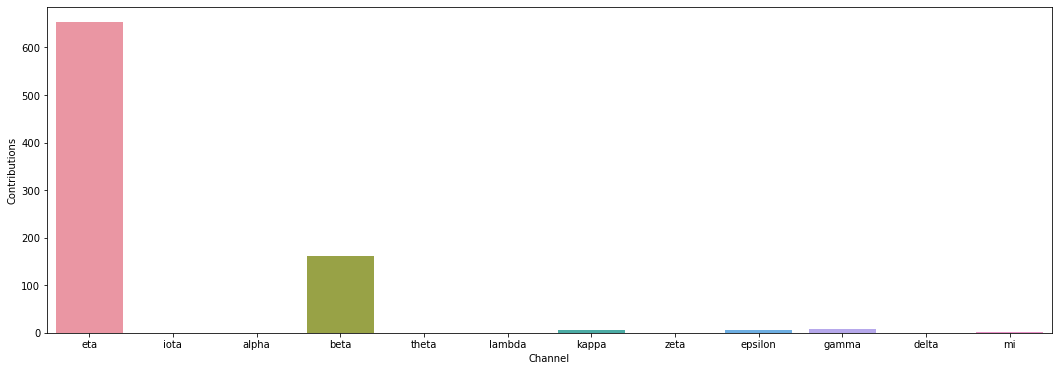

In [58]:
shap = for_shap[['channels_subset','total_conversions']]
visualize(shap,'total_conversions',get_channels(df.steps))

### by a "total conversions" value

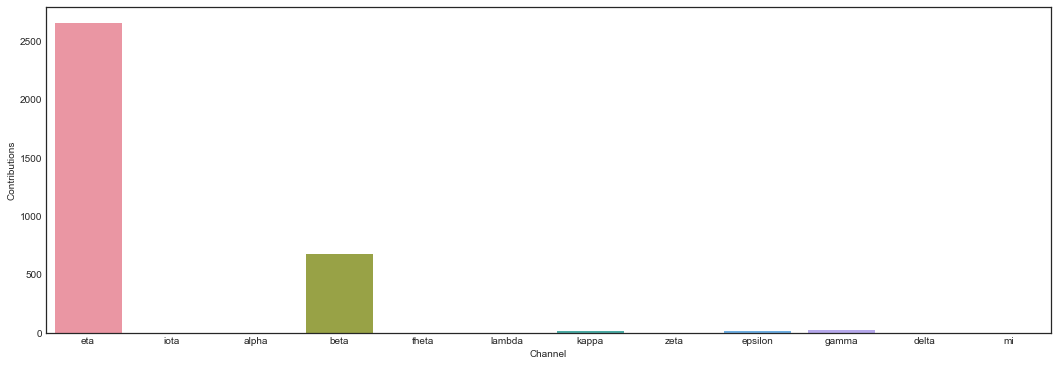

In [115]:
shap = for_shap[['channels_subset','total_conversion_value']]
visualize(shap,'total_conversion_value',get_channels(df.steps))

In both cases eta and beta are the champions 

# Last-click (baseline)

In [104]:
df['last_channel'] = df.steps.apply(lambda x:x[-1])
channels = get_channels(df.steps)
conversions = dict.fromkeys(channels,0)
for index, row in df.iterrows():
    conversions[row['last_channel']]+=1

In [125]:
conversions

{'eta': 3259,
 'iota': 1670,
 'alpha': 1729,
 'beta': 761,
 'theta': 657,
 'lambda': 756,
 'kappa': 252,
 'zeta': 99,
 'epsilon': 523,
 'gamma': 61,
 'delta': 6,
 'mi': 1}

Champions are eta, alpha and iota

# Summary

In [159]:
summarize = pd.DataFrame.from_dict(conversions, orient='index',columns=['last click'])

shap = for_shap[['channels_subset','total_conversion_value']]
shap_res = calculate_shapley(shap,'total_conversion_value',get_channels(df.steps))
shap_res = pd.DataFrame.from_dict(shap_res, orient='index',columns=['Shapley'])

markov_res = mm.attribution_model_.set_index('channel_name').drop('total_revenue',axis=1)
markov_res.rename(columns={"total_conversions": "Markov"},inplace=True)

In [160]:
summary = pd.merge(pd.merge(summarize, shap_res, left_index=True, right_index=True),
          markov_res, left_index=True, right_index=True)

In [161]:
summary

,last click,Shapley,Markov
eta,3259,2658.221043,1807.850113
iota,1670,0.000000,1715.904683
alpha,1729,0.000000,1272.783062
beta,761,682.070267,1512.640706
theta,657,0.000000,957.278007
lambda,756,0.000000,701.122344
kappa,252,15.788750,191.271096
zeta,99,0.000000,269.378585
epsilon,523,15.784000,389.922426
gamma,61,28.248667,121.158861


One may see, that all models chose eta as the best channel but weren't so sure about the other channels 